Based on https://github.com/naokishibuya/car-finding-lane-lines

In [222]:
import matplotlib.pyplot as plt
import cv2
import os, glob 
import copy, math
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
g_silent = False
g_images_dir = ['test_images', 'more_images'][0]
g_dbg_tags = ['contour']
g_dbg_indices = range(6,10)
g_use_roi = False
g_white_low = [0,200,0]

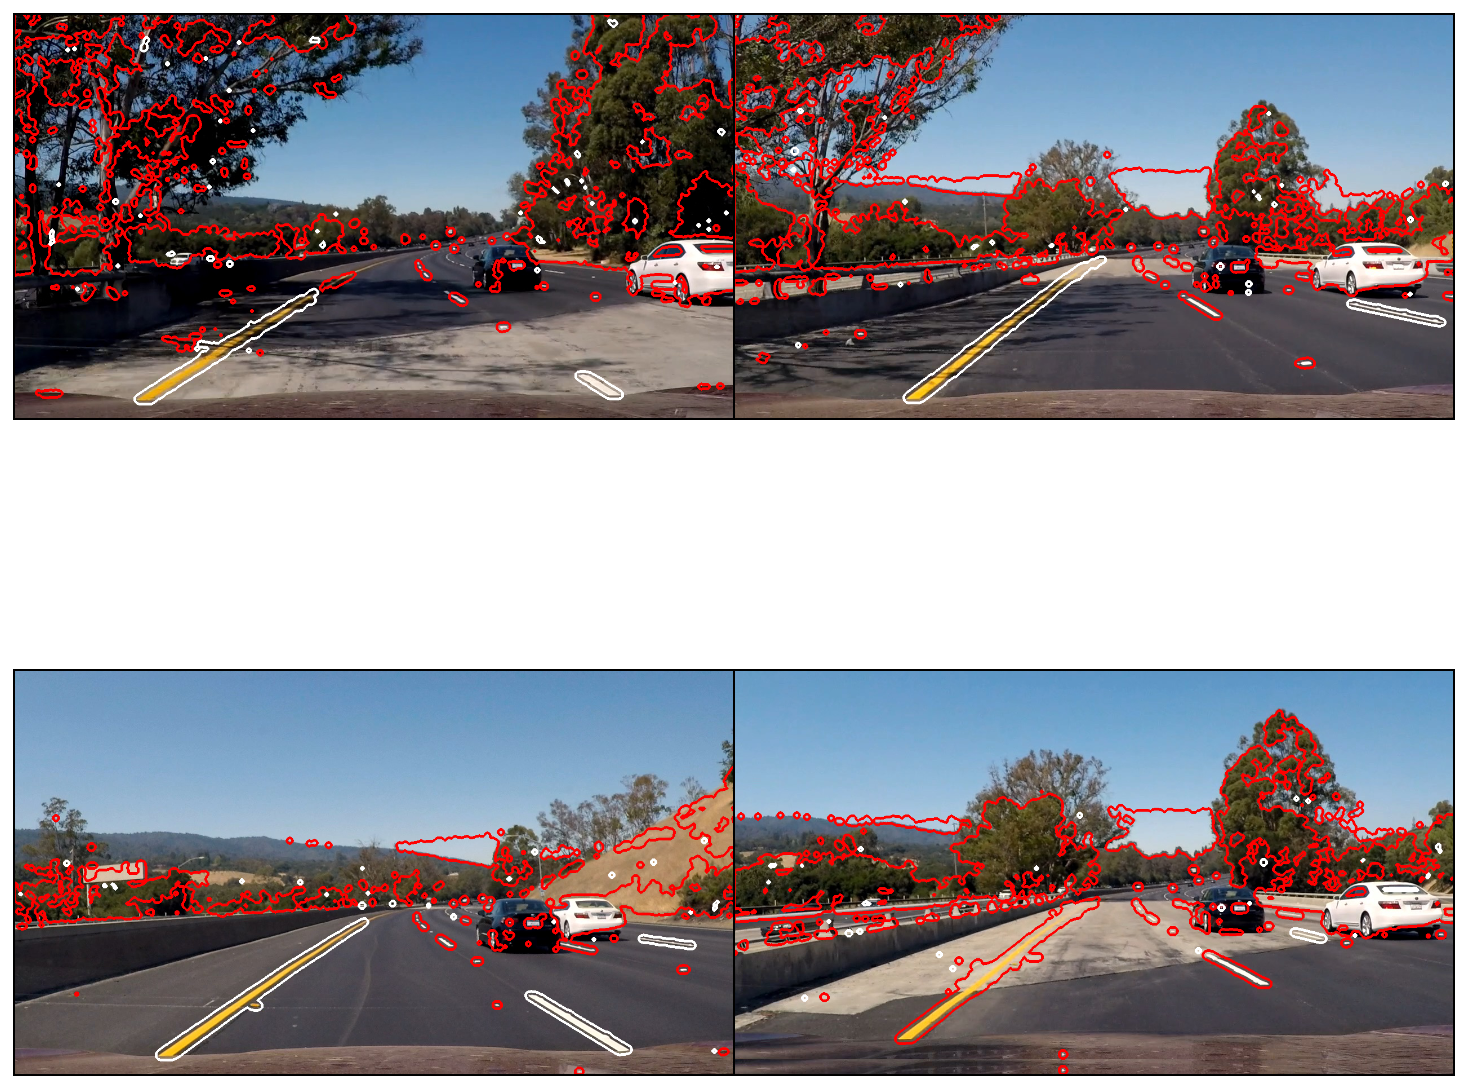

In [230]:
def show_images_(images, cmap = None):
    if len(images) == 0:
        return
    cols = 2
    rows = (len(images)+1)//cols
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    
def show_images(images, tag, cmap=None):
    if g_dbg_tags is None or tag in g_dbg_tags:
        show_images_([images[x] for x in range(len(images)) if g_dbg_indices is None or x in g_dbg_indices], cmap)
src_images = [plt.imread(path) for path in glob.glob('data/{}/*.jpg'.format(g_images_dir))]
show_images(src_images, 'src')

def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
hls_images = list(map(convert_hls, src_images))
show_images(hls_images, 'hls')

def select_white_yellow(hls_image):
    converted = hls_image
    # white color mask
    lower = np.uint8(g_white_low)
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(hls_image, hls_image, mask = mask)

white_yellow_images = list(map(select_white_yellow, hls_images))
show_images(white_yellow_images, 'white_yellow')

def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, white_yellow_images))
show_images(gray_images, 'gray')

def apply_smoothing(image, kernel_size=15):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

blurred_images = list(map(lambda image: apply_smoothing(image), gray_images))
show_images(blurred_images, 'blurred')

if True:
    contour_images = []
    for i, img in enumerate(blurred_images):
        img2, contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        #print len(contours)
        if False:
            contour_images.append(cv2.drawContours(white_yellow_images[i], contours, -1, (0,255,0), 3))
        else:
            if i not in g_dbg_indices:
                contour_images.append(img2)
                continue
            g_plot_hist = False
            def contour_is_lane(contour):
                fix_contour_pt = lambda x: x[0] # I don't get this...
                ang_mpi = lambda x: x >= 180.0 if 360.0 - x else x 
                def vec_samples(vec):
                    multiples = int(math.ceil(np.linalg.norm(vec)))
                    angle = np.arctan2(vec[1], vec[0])
                    abs_angle = (angle + np.pi) if angle < 0.0 else angle
                    abs_angle = np.rad2deg(angle)
                    #print (multiples/2), np.rad2deg(angle)
                    return [abs_angle]*(multiples/3)
                def is_lane_hist(hist, bins):
                    sec,first = sorted(zip(hist, bins), key = lambda x: x[0])[-2:]
                    if first[0] == 0:
                        return False
                    ang_sum = ang_mpi(first[1]) + ang_mpi(sec[1])
                    ang_sum = 0.0 if ang_sum == 180.0 else ang_sum
                    ang_err = abs(ang_sum - 0.0)
                    symm_ratio = float(sec[0])/first[0]
                    all_ratio = float(first[0]+sec[0])/sum(hist)
                    ang_tol = 10; symm_ratio_min = 0.7; 
                    all_ratio_min = 0.6; # TODO: take curved ones into account... cut
                    #print first, sec
                    #print ang_err, symm_ratio, all_ratio
                    return  ang_err <= ang_tol and symm_ratio >= symm_ratio_min and all_ratio >= all_ratio_min
                samples = []
                for i in range(len(contour)-6):
                    #print fix_contour_pt(contour[i+4]), fix_contour_pt(contour[i])
                    v_samples = vec_samples(np.subtract(fix_contour_pt(contour[i+6]), fix_contour_pt(contour[i])))
                    samples.extend(v_samples)
                hist, bins = np.histogram(samples, bins=12)
                ret = is_lane_hist(hist, bins)
                if g_plot_hist:
                    width = 0.7 * (bins[1] - bins[0])
                    center = (bins[:-1] + bins[1:]) / 2
                    plt.bar(center, hist, align='center', width=width)
                    plt.show()
                return ret
            filter_len = 0
            tgt = copy.copy(src_images[i])
            for contour in [x for x in contours[:] if len(x) > filter_len]:
                is_lane = contour_is_lane(contour)
                col = [int(x*255) for x in np.random.rand(3,1)]
                col = [255,255,255] if is_lane else [255,0,0]
                #tgt = copy.copy(white_yellow_images[i])
                if False:
                    for pt in contour:
                        cv2.circle(tgt, tuple(pt[0]), 6, col)
                else:
                    tgt = cv2.drawContours(tgt, [contour], -1, col, 3)
                #show_images_([tgt])
            contour_images.append(tgt)
    show_images(contour_images, 'contour')
    
def detect_edges(image, low_threshold=50, high_threshold=150):
    return cv2.Canny(image, low_threshold, high_threshold)

edge_images = list(map(lambda image: detect_edges(image), blurred_images))
show_images(edge_images, 'edge')